## Cryptocurrency trading bot.

### Install if needed.

In [1]:
##%pip install python-binance==0.7.5
#%pip install python-binance

### Manage API keys and get all needed pair information to trade.

In [2]:
# Import libraries.
from cryptocurrency.authentication import Cryptocurrency_authenticator
from cryptocurrency.exchange import Cryptocurrency_exchange

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

# Display pre-computed exchange info.
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,min_price,max_price,tick_size,step_size,multiplier_up,multiplier_down
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,1.000000e-06,922327.0,1.000000e-06,0.0001,5.0,0.2
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0010,5.0,0.2
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0010,5.0,0.2
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0100,5.0,0.2
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,1.000000e-06,1000.0,1.000000e-06,0.1000,5.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,VITEBUSD,VITE,8,BUSD,8,8,8,8,True,True,1.000000e-05,1000.0,1.000000e-05,0.1000,5.0,0.2
1411,HOOKBTC,HOOK,8,BTC,8,8,8,8,True,True,1.000000e-08,1.0,1.000000e-08,0.1000,5.0,0.2
1412,HOOKUSDT,HOOK,8,USDT,8,8,8,8,True,True,1.000000e-04,1000.0,1.000000e-04,0.1000,5.0,0.2
1413,HOOKBUSD,HOOK,8,BUSD,8,8,8,8,True,True,1.000000e-04,1000.0,1.000000e-04,0.1000,5.0,0.2


### Order book.

In [3]:
import pandas as pd

def get_order_book_depth(client, symbol):
    depth = client.get_order_book(symbol=symbol, limit=5000)
    frames = {side: pd.DataFrame(data=depth[side], columns=['price', 'quantity'], dtype=float) 
              for side in ['bids', 'asks']}
    frames_list = [frames[side].assign(side=side) for side in frames]
    return frames, pd.concat(frames_list, axis='index', ignore_index=True, sort=True)

def order_book_trigger(client, symbol, threshold=10000):
    frames, data = get_order_book_depth(client, symbol)
    min_prices = data.groupby('side').price.min()
    max_prices = data.groupby('side').price.max()
    min_bid_price = min_prices.loc['bids']
    max_bid_price = max_prices.loc['bids']
    min_ask_price = min_prices.loc['asks']
    max_ask_price = max_prices.loc['asks']
    min_quantities = data.groupby('side').quantity.min()
    max_quantities = data.groupby('side').quantity.max()
    min_bid_quantity = min_quantities.loc['bids']
    max_bid_quantity = max_quantities.loc['bids']
    min_ask_quantity = min_quantities.loc['asks']
    max_ask_quantity = max_quantities.loc['asks']
    bid_range = ((max_bid_price - min_bid_price) / min_bid_price) * 100
    ask_range = ((max_ask_price - min_ask_price) / min_ask_price) * 100
    spread = ((min_ask_price - max_bid_price) / min_ask_price) * 100
    width_trigger = ask_range > threshold
    height_trigger = max_ask_quantity > max_bid_quantity
    spread_trigger = spread < 0.8
    return width_trigger and height_trigger and spread_trigger

symbol = 'USTCBUSD'
trigger = order_book_trigger(client=client, symbol=symbol, threshold=10000)
trigger

False

### Screen market.

In [ ]:
from cryptocurrency.conversion import get_timezone_offset_in_seconds
from cryptocurrency.conversion_table import get_conversion_table, get_tradable_tickers_info
from time import sleep

def loop_through_tickers(client, threshold=100):
    def filter_bid_ask_range_in_loop(symbol):
        sleep(2.9)
        return order_book_trigger(client=client, symbol=symbol, threshold=threshold)
    offset_s = get_timezone_offset_in_seconds()
    i = 0
    while True:
        conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                                offset_s=offset_s, as_pair=True, dump_raw=False, 
                                                minimal=True, extra_minimal=False, 
                                                convert_to_USDT=True)
        tickers_list = get_tradable_tickers_info(conversion_table=conversion_table)[1]
        print('len(tickers_list):', len(tickers_list))
        sleep(5)
        for j, symbol in enumerate(tickers_list):
            if filter_bid_ask_range_in_loop(symbol=symbol):
                print('#{}#{}: {} '.format(str(i), str(j), symbol), end='')
        i += 1

loop_through_tickers(client=client, threshold=10000)

/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:231: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['symbol', 'price_change_percent', 'close', 'ask_price',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:285: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['open', 'close', 'bid_price', 'ask_price', 'USDT_open',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:304: FutureWarning: The default value of numeric_only in Dat

len(tickers_list): 355
#0#12: LITUSDT #0#16: VIDTBUSD 

### Plot order book.

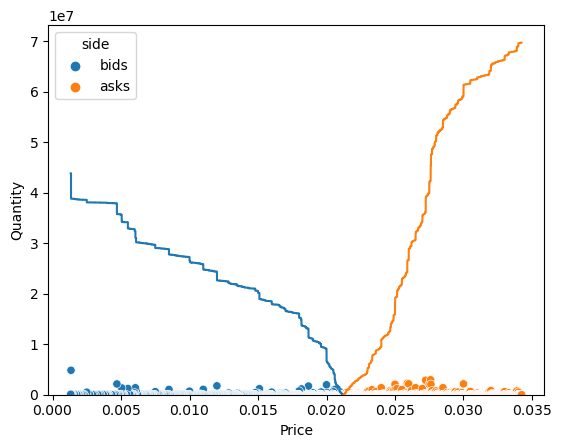

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

frames, data = get_order_book_depth(client, symbol)

fig, ax = plt.subplots()

sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)

ax.set_xlabel('Price')
ax.set_ylabel('Quantity')

plt.show()